# Live trade list quick PnL

Fill the variables below, then run.

rows: 38
portfolio_return: -0.0016008706464743236
return stats:
count    38.000000
mean     -0.001601
std       0.005162
min      -0.008292
25%      -0.004010
50%      -0.002550
75%      -0.000846
max       0.019765
Name: return, dtype: float64


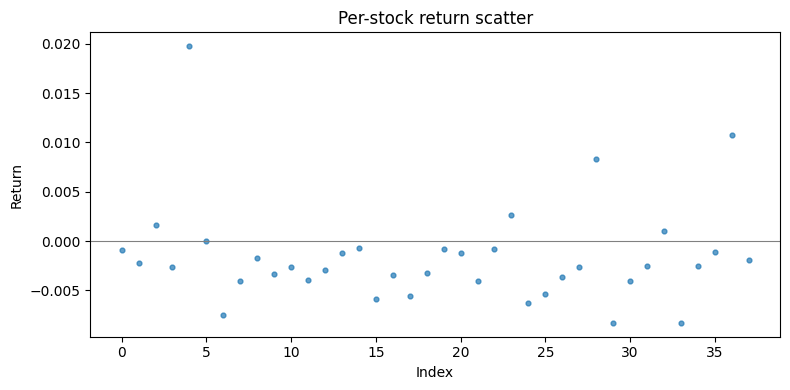

,code,weight,return
0,111019.SH,0.026316,-0.000934
1,113033.SH,0.026316,-0.002201
2,113049.SH,0.026316,0.001633
3,113056.SH,0.026316,-0.002665
4,113066.SH,0.026316,0.019765


In [10]:
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt

# ---- settings ----
trade_day = '2026-01-07'  # trade_list date
signal_name = 'combo_default'
batch_id = 'Live'
results_root = Path('D:/cbond_daily/results')
cleaned_root = Path('D:/cbond_daily/clean_data')

buy_twap_col = 'twap_0930_1000'
sell_twap_col = 'twap_1430_1500'
twap_bps = 1.5
fee_bps = 0.7

# ---- load trade list ----
trade_dir = results_root / 'live' / trade_day / batch_id / signal_name
trade_path = trade_dir / 'trade_list.csv'
trades = pd.read_csv(trade_path)
trades['trade_date'] = pd.to_datetime(trades['trade_date']).dt.date

# ---- load cleaned data for trade_day ----
day = pd.to_datetime(trade_day).date()
month = f'{day.year:04d}-{day.month:02d}'
cleaned_path = cleaned_root / month / f'{day:%Y%m%d}.parquet'
df = pd.read_parquet(cleaned_path)

# ---- merge and compute return ----
merged = trades.merge(df[['code', buy_twap_col, sell_twap_col]], on='code', how='left')

def apply_bps(px, bps, side):
    if side == 'buy':
        return px * (1 + bps / 10000.0)
    return px * (1 - bps / 10000.0)

cost_bps = twap_bps + fee_bps
buy_px = apply_bps(merged[buy_twap_col], cost_bps, 'buy')
sell_px = apply_bps(merged[sell_twap_col], cost_bps, 'sell')
merged['return'] = (sell_px - buy_px) / buy_px

# ---- summary ----
merged['weight'] = merged.get('weight', 1.0 / len(merged))
merged['weight'] = merged['weight'].fillna(0.0)
port_ret = float((merged['return'] * merged['weight']).sum())
print('rows:', len(merged))
print('portfolio_return:', port_ret)

# ---- per-stock stats ----
stats = merged['return'].describe()
print('return stats:')
print(stats)

# ---- scatter plot ----
plt.figure(figsize=(8, 4))
plt.scatter(range(len(merged)), merged['return'], s=12, alpha=0.7)
plt.axhline(0, color='gray', linewidth=0.8)
plt.title('Per-stock return scatter')
plt.xlabel('Index')
plt.ylabel('Return')
plt.tight_layout()
plt.show()
merged[['code', 'weight', 'return']].head()


In [11]:
merged

,trade_date,code,weight,twap_0930_1000,twap_1430_1500,return
0,2026-01-07,111019.SH,0.026316,140.3902,140.3208,-9.340223e-04
1,2026-01-07,113033.SH,0.026316,114.6729,114.4709,-2.200660e-03
2,2026-01-07,113049.SH,0.026316,116.8635,117.1058,1.632544e-03
3,2026-01-07,113056.SH,0.026316,126.9901,126.7074,-2.665082e-03
4,2026-01-07,113066.SH,0.026316,143.2080,146.1028,1.976516e-02
5,2026-01-07,113584.SH,0.026316,119.2181,119.2705,-5.659976e-07
6,2026-01-07,113623.SH,0.026316,146.4352,145.4041,-7.478146e-03
7,2026-01-07,113634.SH,0.026316,128.4151,127.9519,-4.045369e-03
8,2026-01-07,113647.SH,0.026316,123.0283,122.8720,-1.709784e-03
9,2026-01-07,113665.SH,0.026316,129.9276,129.5569,-3.291776e-03
